In [9]:
from sigvisa.treegp.bcm.multi_shared_bcm import MultiSharedBCM, Blocker, sample_synthetic
from sigvisa.treegp.bcm.local_regression import BCM

from sigvisa.treegp.gp import GPCov, GP, mcov, prior_sample, dgaussian
from sigvisa.utils.fileutils import mkdir_p
import scipy.stats
import scipy.optimize
import time
import os

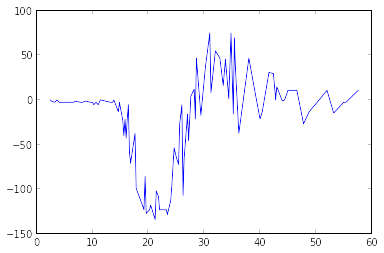

In [10]:
# http://www.stat.cmu.edu/~larry/all-of-statistics/=data/motor.dat
### Motorcycle Data
### Data from a Simulated Motorcycle Accident
### 
### SUMMARY:
###        The motor data frame has 94 rows and 4 columns.  The  rows
###        are obtained by removing replicate values of time from the
###        dataset mcycle.  Two extra columns are added to allow  for
###        strata with a different residual variance in each stratum.
###        ~give succinct details here
### 
### DATA DESCRIPTION:
###        This data frame contains the following columns:
### times:    The time in milliseconds since impact.
### accel:    The recorded head acceleration (in g).
### strata:   A numeric column  indicating  to  which  of  the  three
###        strata (numbered 1, 2 and 3) the observations belong.
### v:     An estimate of the residual variance for the  observation.
###        v  is  constant within the strata but a different estimate
###        is used for each of the three strata.
### 
### SOURCE:
###        The data were obtained from
### 
###        Silverman,  B.W.  (1985)  Some  aspects  of   the   spline
###        smoothing   approach   to  non-parametric  curve  fitting.
###        Journal of the Royal Statistical Society, B, 47, 1-52.
### 
### OTHER REFERENCES:
###        Davison, A.C. and Hinkley, D.V. (1997)  Bootstrap  Methods
###        and Their Application. Cambridge University Press.
### 
###        Venables, W.N. and  Ripley,  B.D.  (1994)  Modern  Applied
###        Statistics with S-Plus. Springer-Verlag.
### 
### 

#times	accel	strata	v
d = """2.4	0	1	3.7
2.6	-1.3	1	3.7
3.2	-2.7	1	3.7
3.6	0	1	3.7
4	-2.7	1	3.7
6.2	-2.7	1	3.7
6.6	-2.7	1	3.7
6.8	-1.3	1	3.7
7.8	-2.7	1	3.7
8.2	-2.7	1	3.7
8.8	-1.3	1	3.7
9.6	-2.7	1	3.7
10	-2.7	1	3.7
10.2	-5.4	1	3.7
10.6	-2.7	1	3.7
11	-5.4	1	3.7
11.4	0	1	3.7
13.2	-2.7	2	607
13.6	-2.7	2	607
13.8	0	2	607
14.6	-13.3	2	607
14.8	-2.7	2	607
15.4	-22.8	2	607
15.6	-40.2	2	607
15.8	-21.5	2	607
16	-42.9	2	607
16.2	-21.5	2	607
16.4	-5.4	2	607
16.6	-59	2	607
16.8	-71	2	607
17.6	-37.5	2	607
17.8	-99.1	2	607
18.6	-112.5	2	607
19.2	-123.1	2	607
19.4	-85.6	2	607
19.6	-127.2	2	607
20.2	-123.1	2	607
20.4	-117.9	2	607
21.2	-134	2	607
21.4	-101.9	2	607
21.8	-108.4	2	607
22	-123.1	2	607
23.2	-123.1	2	607
23.4	-128.5	2	607
24	-112.5	2	607
24.2	-95.1	2	607
24.6	-53.5	2	607
25	-64.4	2	607
25.4	-72.3	2	607
25.6	-26.8	2	607
26	-5.4	2	607
26.2	-107.1	2	607
26.4	-65.6	2	607
27	-16	2	607
27.2	-45.6	2	607
27.6	4	2	607
28.2	12	2	607
28.4	-21.5	2	607
28.6	46.9	2	607
29.4	-17.4	2	607
30.2	36.2	2	607
31	75	2	607
31.2	8.1	2	607
32	54.9	2	607
32.8	46.9	2	607
33.4	16	2	607
33.8	45.6	2	607
34.4	1.3	2	607
34.8	75	2	607
35.2	-16	2	607
35.4	69.6	2	607
35.6	34.8	2	607
36.2	-37.5	2	607
38	46.9	2	607
39.2	5.4	2	607
39.4	-1.3	2	607
40	-21.5	2	607
40.4	-13.3	2	607
41.6	30.8	3	138
42.4	29.4	3	138
42.8	0	3	138
43	14.7	3	138
44	-1.3	3	138
44.4	0	3	138
45	10.7	3	138
46.6	10.7	3	138
47.8	-26.8	3	138
48.8	-13.3	3	138
50.6	0	3	138
52	10.7	3	138
53.2	-14.7	3	138
55	-2.7	3	138
55.4	-2.7	3	138
57.6	10.7	3	138"""

lines = d.split("\n")
stuff = [[float(x) for x in l.split("\t")[:2]] for l in lines]
mdata = np.array(stuff)
times = mdata[:, 0]
accel = mdata[:, 1]
plot(times, accel)
X = times.reshape((-1, 1))
Y = accel.reshape((-1, 1))

In [66]:


centers = [np.array((10,)), np.array((40,))]
#centers = [np.array((0.25, 0.25)),]
b = Blocker(centers)
SX, SY, perm, block_boundaries = b.sort_by_block(X, Y)

noise_var = 1.0
lscale2 = 5.0
cov = GPCov(wfn_params=[1.1], dfn_params=[lscale2,], dfn_str="euclidean", wfn_str="se")

mbcm = MultiSharedBCM(SX, SY, block_boundaries, cov, noise_var, 
                      nonstationary=True, neighbor_threshold=5.0, nonstationary_prec=True)

In [67]:

nonstationary_hparam_covs = {"noise_var": (0.0, GPCov(wfn_params=[2.0], dfn_params=[10.0, ], 
                                                      dfn_str="euclidean", wfn_str="se")),
                             "signal_var": (0.0, GPCov(wfn_params=[2.0], dfn_params=[10.0, ], 
                                                      dfn_str="euclidean", wfn_str="se")),
                             "lscale": (0.0, GPCov(wfn_params=[2.0], dfn_params=[10.0, ], 
                                                      dfn_str="euclidean", wfn_str="se"))
                             }
CX = np.array(centers, dtype=float)
hparam_cov = mcov(CX, nonstationary_hparam_covs["noise_var"][1], nonstationary_hparam_covs["noise_var"][0])
hparam_prec = np.linalg.inv(hparam_cov)
hparam_logdet = np.linalg.slogdet(hparam_cov)[1]

def gaussian_llgrad(y, prec, logdet):
    alpha = np.dot(prec, y)
    ll =  -.5 * np.dot(y, alpha)
    ll += -.5 * logdet
    ll += -.5 * len(y) * np.log(2*np.pi)
    
    llgrad = -alpha
    return ll, llgrad

def gll(yy):
    return gaussian_llgrad(yy, hparam_prec, hparam_logdet)[0]

y0= np.random.randn(5)


In [68]:
init_covs = [(np.log(0.01), np.log(1.0), np.log(0.3)),] * len(centers)
init_covs = np.array(init_covs)
C0 = init_covs

#init_covs = np.hstack([np.log(block_nv.reshape((-1, 1))), np.log(block_sv.reshape((-1, 1))), np.log(block_lscale.reshape((-1, 1)))])
#print init_covs

x0 = init_covs.flatten()
#x0 = np.random.randn(len(x0))


def cov_prior(c):
    cr = c.reshape(C0.shape)
    nv = cr[:, 0] - 2.0
    sv = cr[:, 1] - 2.0
    ls = cr[:, 2] - 1.0
    
    nvll, nvgrad = gaussian_llgrad(nv, hparam_prec, hparam_logdet)
    svll, svgrad = gaussian_llgrad(sv, hparam_prec, hparam_logdet)
    lsll, lsgrad = gaussian_llgrad(ls, hparam_prec, hparam_logdet)
    
    ll = nvll + svll + lsll
    lderiv = np.hstack([nvgrad.reshape((-1, 1)), svgrad.reshape((-1, 1)), lsgrad.reshape((-1, 1))])
    #print lderiv
    lderiv = lderiv.flatten()
    #print lderiv
    return ll, lderiv

"""
def cov_prior(c):
    mean = -1
    std = 3
    
    cr = c.reshape(C0.shape)
    
    
    ls = cr[:, 2]
    
    nv = cr[:, 0]
    nv_mean = 2.0
    nv_std = 2.0
    rnv = (nv-nv_mean)/nv_std
    ll_nv = -.5*np.sum( rnv**2)- .5 *len(nv) * np.log(2*np.pi*nv_std**2)
    lderiv_nv = -(nv-nv_mean)/(nv_std**2)
    
    sv = cr[:, 1]
    sv_mean = 2.0
    sv_std = 2.0
    rsv = (sv-sv_mean)/sv_std
    ll_sv = -.5*np.sum( rsv**2)- .5 *len(sv) * np.log(2*np.pi*sv_std**2)
    lderiv_sv = -(sv-sv_mean)/(sv_std**2)
    
    
    ls = cr[:, 2]
    ls_mean = 2.0
    ls_std = 1.0
    rls = (ls-ls_mean)/ls_std
    ll_ls = -.5*np.sum( rls**2)- .5 *len(ls) * np.log(2*np.pi*ls_std**2)
    lderiv_ls = -(ls-ls_mean)/(ls_std**2)
    
    
    ll = ll_sv + ll_ls + ll_nv
    lderiv = np.hstack([lderiv_nv.reshape((-1, 1)), lderiv_sv.reshape((-1, 1)), lderiv_ls.reshape((-1, 1))])
    #print lderiv
    lderiv = lderiv.flatten()
    #print lderiv
    return ll, lderiv
"""
def llgrad_cov(c):    
    cs = c.reshape(init_covs.shape)
    cs = np.exp(cs)
    mbcm.update_covs(cs)
    ll, gx, gc = mbcm.llgrad(grad_cov=True)
    
    prior_ll, prior_grad = cov_prior(c)
    ll += prior_ll
    gc = (np.array(gc) * cs).flatten() + prior_grad
    print ll
    return -ll, -gc.flatten()
    
 

bounds = [(-9, 10),] * len(x0)


r = scipy.optimize.minimize(llgrad_cov, x0, bounds=bounds, jac=True)
print r

-121852.234424
-713.74447003
-713.196188453
-711.014512142
-702.471608885
-671.241652088
-1634.97383332
-592.524258129
-594.885596856
-581.87614828
-575.801854504
-554.549019013
-73724.4516355
-540.910283095
-10985.0589083
-529.758170345
-526.810613509
-526.296924313
-523.165436136
-4761.95064974
-523.16037882
-523.099635103
-520.84604816
-520.722938435
-520.717904346
-520.717725056
-520.716722449
-520.715777081
-520.715214572
-520.715205759
-520.715205614
  status: 0
 success: True
    nfev: 31
     fun: 520.71520561411842
       x: array([ 2.06347523,  7.73540117, -1.24049999,  2.06347523,  7.73540117,
       -1.24049999])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([  2.72746151e-05,  -5.89880258e-05,   1.81240211e-05,
         2.72746151e-05,  -5.89880258e-05,   1.81240211e-05])
     nit: 16


In [69]:
print mbcm.neighbors

[(1, 0)]


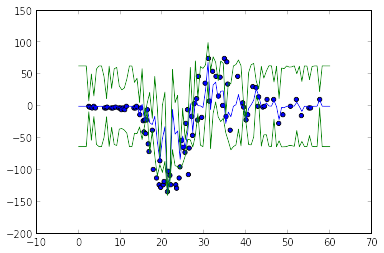

In [70]:
cov = GPCov(wfn_params=[1000.0], dfn_params=[10.0,], dfn_str="euclidean", wfn_str="se")

pred = mbcm.train_predictor(test_cov=cov)
test_n = 100
xs_out = np.linspace(0, 60, test_n)

means = np.zeros((test_n,))
vs1 = np.zeros((test_n,))
vs2 = np.zeros((test_n,))

for i in range(test_n):
    Xs = np.array((xs_out[i],)).reshape((1, -1))
    means[i], vs1[i] = pred(Xs, test_noise_var=0.0, local=False)

plot(xs_out, means)
plot(xs_out, means+2*np.sqrt(vs1), c="green")
plot(xs_out, means-2*np.sqrt(vs1), c="green")
scatter(times, accel)

10 unaries in 0.00737881660461 seconds
9 pairs in 0.0422749519348 seconds
-7956.72445592
10 unaries in 0.00637316703796 seconds
9 pairs in 0.0401349067688 seconds
-927.00417455
10 unaries in 0.00653600692749 seconds
9 pairs in 0.0403299331665 seconds
-915.95141799
10 unaries in 0.00647401809692 seconds
9 pairs in 0.0401749610901 seconds
-872.58772585
10 unaries in 0.00662994384766 seconds
9 pairs in 0.0421710014343 seconds
-703.282527102
10 unaries in 0.00668001174927 seconds
9 pairs in 0.0415599346161 seconds
-24899.5359443
10 unaries in 0.00662517547607 seconds
9 pairs in 0.0422778129578 seconds
-416.251894963
10 unaries in 0.00670504570007 seconds
9 pairs in 0.0415420532227 seconds
-1494.47574495
10 unaries in 0.00672388076782 seconds
9 pairs in 0.0421440601349 seconds
-315.899132435
10 unaries in 0.00663900375366 seconds
9 pairs in 0.0420751571655 seconds
-299.460365985
10 unaries in 0.00665020942688 seconds
9 pairs in 0.0419178009033 seconds
-762.718212492
10 unaries in 0.00677490

KeyboardInterrupt: 

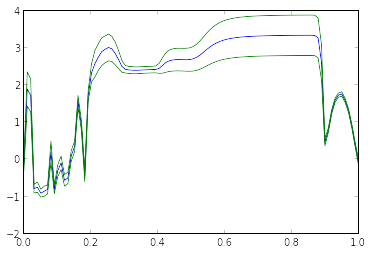

In [14]:
pred = mbcm.train_predictor(test_cov=cov)
test_n = 100
xs_out = np.linspace(0, 1, test_n)

means = np.zeros((test_n,))
vs1 = np.zeros((test_n,))
vs2 = np.zeros((test_n,))

for i in range(test_n):
    Xs = np.array((xs_out[i],)).reshape((1, -1))
    means[i], vs1[i] = pred(Xs, test_noise_var=0.01, local=False)

plot(xs_out, means)
plot(xs_out, means+2*np.sqrt(vs1), c="green")
plot(xs_out, means-2*np.sqrt(vs1), c="green")


In [62]:
print llgrad_cov(x0)


10 unaries in 0.0187029838562 seconds
9 pairs in 0.0414679050446 seconds
(1912836.6126252247, array([[ -6.82730747e+05,  -2.32621032e+04,   1.68737614e+05],
       [ -6.82772048e+05,  -2.32761008e+04,   1.68868311e+05],
       [ -1.25439802e+03,  -1.84599250e+01,   1.68794287e+02],
       [ -1.42123187e+03,   6.85900270e+01,  -4.25397225e+02],
       [ -9.59388206e+02,  -8.87626351e+00,   8.04121461e+01],
       [ -9.65723737e+02,  -9.55317372e+00,   7.59029078e+01],
       [ -1.12149501e+05,  -4.04329424e+01,   2.82117196e+02],
       [ -1.47983038e+04,  -1.97110095e+02,   1.66711791e+03],
       [ -2.47749711e+05,  -2.82103902e+02,   2.25800761e+03],
       [ -1.22573840e+05,  -1.09298636e+02,   8.41512058e+02]]))


In [8]:
pred = mbcm.train_predictor(test_cov=cov)

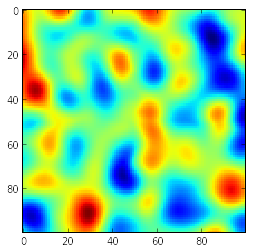

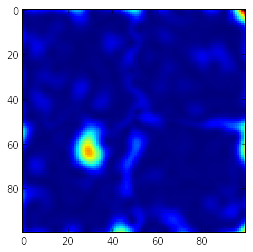

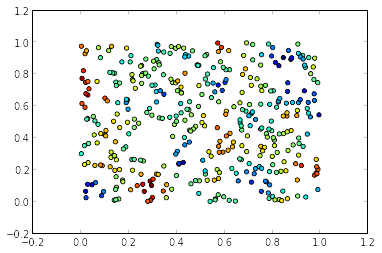

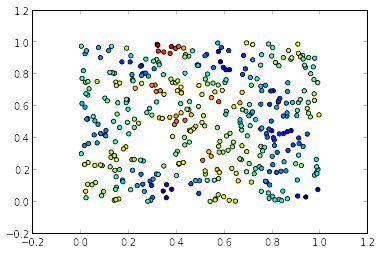

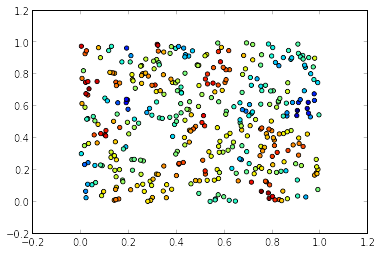

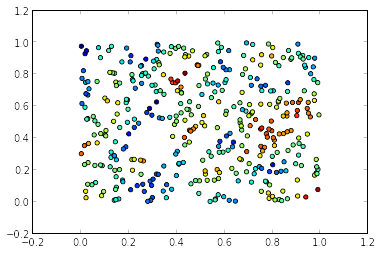

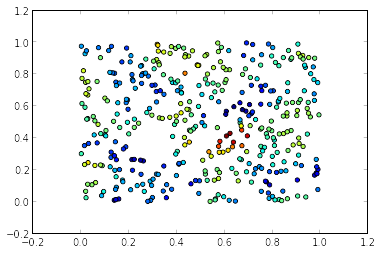

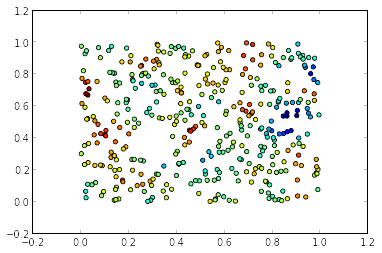

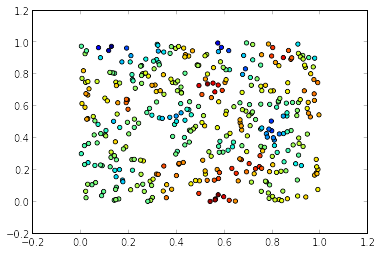

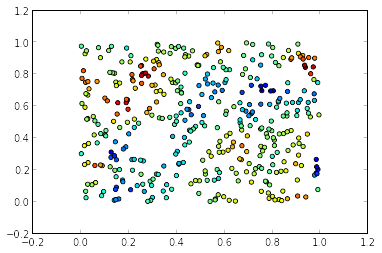

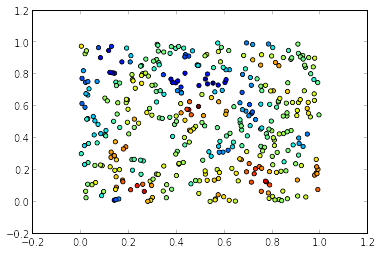

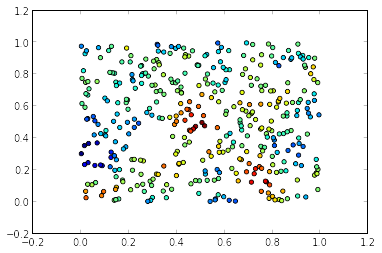

In [9]:
def vis(X, y):
    for i in range(y.shape[1]):
        figure()
        scatter(X[:, 0], X[:, 1], c=y[:,i], cmap="jet")

test_n = 100
xs = np.linspace(0, 1, test_n)
pts = np.array([(x1, x2) for x1 in xs for x2 in xs])

means = np.zeros((test_n,test_n))
vs = np.zeros((test_n,test_n))
for i in range(test_n):
    for j in range(test_n):
        Xs = np.array((xs[i], xs[j])).reshape((1, -1))
        means[test_n-1-j,i], vs[test_n-1-j,i] = pred(Xs, local=False)

        
imshow(means, interpolation="none")
figure()
imshow(vs, interpolation="none")

vis(SX, SY)

In [4]:
X0 = np.array([(0.01, 1.0, 0.1, 0.1),]*4)
x0 = X0.flatten()
print X0.shape
def llc(cov_params):
    CP = cov_params.reshape(X0.shape)
    mbcm.update_covs(CP)
    return mbcm.llgrad()[0]

mbcm.update_covs(X0)
print mbcm.llgrad(grad_cov=True, grad_X=True)


print scipy.optimize.approx_fprime(x0, llc, 1e-6)

#print mbcm.gaussian_llgrad(X=SX[:100], Y=SY[:100, 0:1], grad_cov=True, block_i=0)

(4, 4)
4 unaries in 0.0364170074463 seconds
6 pairs in 0.602379798889 seconds
(-48.606484571718113, array([[ -4.53401308e+00,   3.14881004e+01],
       [  1.96304764e+02,  -2.41546762e+01],
       [  4.01724702e+01,  -1.43273798e+01],
       [ -3.03653762e+01,   1.08243372e+02],
       [ -1.69756582e+02,   4.65569233e+01],
       [  1.04381032e+02,  -9.19780229e+01],
       [  1.54845808e+02,  -1.83128500e+02],
       [  8.20549832e-01,  -3.94682655e+02],
       [  5.20683573e+01,   1.79410064e+02],
       [ -8.11749917e+00,  -1.15360761e+01],
       [ -1.72259654e+02,   1.32083659e+02],
       [ -9.28765934e+01,  -8.44760471e+01],
       [  2.89715725e+02,   6.91664594e+01],
       [  5.30874671e+01,   1.61799571e+00],
       [ -3.49560368e+01,  -4.59954084e+01],
       [  1.20269470e+01,  -3.78300533e+01],
       [  2.69239846e+01,   1.61986213e+01],
       [  6.09403961e+01,   1.26412951e+02],
       [ -9.25129106e+01,  -2.13124246e+02],
       [ -7.51651449e+00,  -9.77448916e+00],


In [7]:
gp = GP(X=SX, y=SY[:, 0:1], cov_main=cov, noise_var=noise_var, sort_events=False, sparse_invert=False, compute_ll=True, compute_grad=True)

In [8]:
print gp.log_likelihood()

[-48.8779853]


In [10]:
print gp.ll_grad

[-1035.00947944    -5.2378049    -80.64711056   447.00323684]
